### Neural Collaborative Filtering
- https://arxiv.org/pdf/1708.05031v2.pdf


- Official NCF implementation [Keras with Theano]: https://github.com/hexiangnan/neural_collaborative_filtering

In [ ]:
!pip install tf_slim
!pip install gdown
!pip install recommenders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD
import random
random.seed(0)
np.random.seed(0)

In [ ]:

from datetime import datetime, timedelta

from recommenders.datasets.python_splitters import (
    python_chrono_split
   
)

In [ ]:
SEED = 42
np.random.seed(SEED)

## Analyse Dataset

### Amazon product review   Dataset
- https://www.kaggle.com/datasets/saurav9786/amazon-product-reviews?resource=download

In [ ]:
!gdown https://drive.google.com/uc?id=1dFuCcqIO0_vQcNg_47Ondz3akBG1ojzb

Downloading...
From: https://drive.google.com/uc?id=1dFuCcqIO0_vQcNg_47Ondz3akBG1ojzb
To: /content/ratings_Electronics.csv
100% 319M/319M [00:00<00:00, 322MB/s]


#### Consider movies rated by more than 30 users

In [ ]:
rating_df =pd.read_csv('ratings_Electronics.csv',  names=['userId','item','rating','time'])
rating_df=rating_df[['userId','item','rating','time']]

x = rating_df.groupby('item').count()['rating'] >= 30
itemIndex = x[x].index
nm_rating_df=rating_df[rating_df['item'].isin(itemIndex)]
y = nm_rating_df.groupby('userId').count()['rating']>=50
users = y[y].index
rating_df = nm_rating_df[nm_rating_df['userId'].isin(users)]
rating_df.shape

(61359, 4)

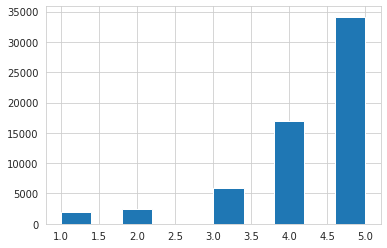

In [ ]:
rating_df['rating'].hist()

In [ ]:
unique_users = rating_df.userId.unique()
user_ids = dict(zip(unique_users, np.arange(unique_users.shape[0], dtype=np.int32)))

unique_items = rating_df.item.unique()
item_ids = dict(zip(unique_items, np.arange(unique_items.shape[0], dtype=np.int32)))

In [ ]:
rating_df['userID'] = rating_df.userId.apply(lambda u: user_ids[u])
rating_df['itemID'] = rating_df.item.apply(lambda m: item_ids[m])

In [ ]:
rating_df.head()

,userId,item,rating,time,userID,itemID
118,AT09WGFUM934H,0594481813,3.0,1377907200,0,0
631,A3TAS1AG6FMBQW,0972683275,5.0,1353456000,1,1
1310,A3LDPF5FMB782Z,1400501466,5.0,1336003200,2,2
1335,A2XIOXRRYX0KZY,1400501466,3.0,1371686400,3,2
1588,A3LDPF5FMB782Z,1400501520,5.0,1362873600,2,3


### Prepare train test set

In [ ]:
final_ratings=rating_df.sort_values(by=['userID','time'], ascending=[False,False]) 
final_ratings.shape

(61359, 6)

In [ ]:
test_df=final_ratings.groupby('userID').head(10)
test_df.shape

(7830, 6)

In [ ]:
final_ratings=final_ratings[~final_ratings.isin(test_df).all(1)]
final_ratings.shape

(53529, 6)

In [ ]:
train_df=final_ratings

In [ ]:
test_df = test_df[test_df["userID"].isin(train_df["userID"].unique())]
test_df = test_df[test_df["itemID"].isin(train_df["itemID"].unique())]

In [ ]:
test_df.head(1)

,userId,item,rating,time,userID,itemID
7583502,A38C12950IM24P,B00EZL1IQA,2.0,1404777600,782,17337


In [ ]:
train_file = "./train.csv"
test_file = "./test.csv"
train_df.to_csv(train_file, index=False)
test_df.to_csv(test_file, index=False)


### Use NCF using recommenders

In [ ]:
import tensorflow as tf
from recommenders.utils.timer import Timer
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.models.ncf.dataset import Dataset as NCFDataset
from recommenders.datasets import movielens
from recommenders.utils.notebook_utils import is_jupyter
from recommenders.datasets.python_splitters import python_chrono_split
from recommenders.evaluation.python_evaluation import (rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k, 
                                                     recall_at_k, get_top_k_items)

In [ ]:
data = NCFDataset(train_file=train_file, test_file=test_file, seed=SEED, overwrite_test_file_full=True)

INFO:recommenders.models.ncf.dataset:Indexing ./train.csv ...
INFO:recommenders.models.ncf.dataset:Indexing ./test.csv ...
INFO:recommenders.models.ncf.dataset:Creating full leave-one-out test file ./test_full.csv ...
100%|██████████| 783/783 [00:11<00:00, 65.48it/s]
INFO:recommenders.models.ncf.dataset:Indexing ./test_full.csv ...


Train NeuMF based on TensorFlow

In [ ]:
EPOCHS=100
BATCH=256
LAYER=[512,256,32]
LR=1e-3
model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=LAYER,
    n_epochs=EPOCHS,
    batch_size=BATCH,
    learning_rate=LR,
    verbose=10,
    seed=SEED
)

In [ ]:
with Timer() as timer:
    model.fit(data)

print("Took {} seconds for training.".format(timer.interval))

INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [7.27s]: train_loss = 0.138370 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [7.32s]: train_loss = 0.070855 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [7.47s]: train_loss = 0.045820 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [7.71s]: train_loss = 0.031617 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [7.34s]: train_loss = 0.024871 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [7.35s]: train_loss = 0.020743 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [7.50s]: train_loss = 0.016867 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [7.33s]: train_loss = 0.013515 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [7.64s]: train_loss = 0.012826 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [7.31s]: train_loss = 0.011233 


Took 742.5365185900002 seconds for training.


In [ ]:
predictions = [[row.userID, row.itemID, model.predict(row.userID, row.itemID)]
               for (_, row) in test_df.iterrows()]


predictions = pd.DataFrame(predictions, columns=['userID', 'itemID', 'prediction'])
predictions.head(5)

,userID,itemID,prediction
0,782,17337,7.925717e-25
1,782,17557,1.338104e-27
2,782,17530,1.439728e-05
3,782,17601,2.293599e-05
4,782,12150,3.138693e-15


### Evaluation

In [ ]:
with Timer() as test_time:

    users, items, preds = [], [], []
    item = list(train_df.itemID.unique())
    for user in train_df.userID.unique():
        user = [user] * len(item) 
        users.extend(user)
        items.extend(item)
        preds.extend(list(model.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

    merged = pd.merge(train_df, all_predictions, on=["userID", "itemID"], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

print("Took {} seconds for prediction.".format(test_time.interval))

Took 55.912595424999836 seconds for prediction.


In [ ]:
TOP_K=20
eval_map = map_at_k(test_df, all_predictions, col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(test_df, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test_df, all_predictions, col_prediction='prediction', k=TOP_K)

print("MAP:\t%f" % eval_map,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.002681
Precision@K:	0.005683
Recall@K:	0.014708


In [ ]:
k = 20

ndcgs = []
hit_ratio = []

for b in data.test_loader():
    user_input, item_input, labels = b
    output = model.predict(user_input, item_input, is_list=True)

    output = np.squeeze(output)
    rank = sum(output >= output[0])
    if rank <= k:
        ndcgs.append(1 / np.log(rank + 1))
        hit_ratio.append(1)
    else:
        ndcgs.append(0)
        hit_ratio.append(0)

eval_ndcg = np.mean(ndcgs)
eval_hr = np.mean(hit_ratio)

print("Hit Rate:\t%f" % eval_hr)
print("Normalized Discounted Cumulative Gain :\t%f" % eval_ndcg)

Hit Rate:	0.529966
Normalized Discounted Cumulative Gain :	0.351440


### Combine GMF and MLP

In [ ]:
EPOCHS=100
BATCH=256
LAYER=[512,256,32]
LR=1e-3
model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="GMF",
    n_factors=4,
    layer_sizes=LAYER,
    n_epochs=EPOCHS,
    batch_size=BATCH,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)

In [ ]:
with Timer() as train_time:
    model.fit(data)

print("Took {} seconds for training.".format(train_time.interval))

model.save(dir_name=".pretrain/GMF")

INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [5.66s]: train_loss = 0.400708 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [5.72s]: train_loss = 0.337412 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [5.62s]: train_loss = 0.310052 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [5.73s]: train_loss = 0.300724 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [6.11s]: train_loss = 0.294986 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [5.73s]: train_loss = 0.290373 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [5.68s]: train_loss = 0.288229 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [6.16s]: train_loss = 0.283714 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [5.69s]: train_loss = 0.281355 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [5.71s]: train_loss = 0.279002 


Took 582.3236116769999 seconds for training.


In [ ]:

EPOCHS=100
BATCH=256
LAYER=[512,256,32]
LR=1e-3
model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="MLP",
    n_factors=4,
    layer_sizes=LAYER,
    n_epochs=EPOCHS,
    batch_size=BATCH,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)

In [ ]:
with Timer() as train_time:
    model.fit(data)

print("Took {} seconds for training.".format(train_time.interval))

model.save(dir_name=".pretrain/MLP")

INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [6.44s]: train_loss = 0.051567 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [6.39s]: train_loss = 0.037214 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [6.89s]: train_loss = 0.028291 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [6.36s]: train_loss = 0.021930 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [6.44s]: train_loss = 0.018112 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [6.76s]: train_loss = 0.015769 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [6.48s]: train_loss = 0.012886 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [6.67s]: train_loss = 0.011296 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [6.50s]: train_loss = 0.010129 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [6.46s]: train_loss = 0.009272 


Took 657.7082472080001 seconds for training.


In [ ]:
EPOCHS=100
BATCH=256
LAYER=[512,256,32]
LR=1e-3
model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=LAYER,
    n_epochs=EPOCHS,
    batch_size=BATCH,
    learning_rate=LR,
    verbose=10,
    seed=SEED
)
model.load(gmf_dir=".pretrain/GMF", mlp_dir=".pretrain/MLP", alpha=0.5)

INFO:tensorflow:Restoring parameters from .pretrain/GMF/model.ckpt


INFO:tensorflow:Restoring parameters from .pretrain/GMF/model.ckpt


INFO:tensorflow:Restoring parameters from .pretrain/MLP/model.ckpt


INFO:tensorflow:Restoring parameters from .pretrain/MLP/model.ckpt


In [ ]:
with Timer() as train_time:
    model.fit(data)

print("Took {} seconds for training.".format(train_time.interval))

INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [7.36s]: train_loss = 0.008024 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [7.54s]: train_loss = 0.006780 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [7.31s]: train_loss = 0.006184 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [7.32s]: train_loss = 0.006193 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [7.30s]: train_loss = 0.005361 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [7.40s]: train_loss = 0.005098 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [7.76s]: train_loss = 0.004915 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [7.41s]: train_loss = 0.004251 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [7.26s]: train_loss = 0.004169 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [7.40s]: train_loss = 0.004054 


Took 746.7082576530001 seconds for training.


In [ ]:
with Timer() as test_time:

    users, items, preds = [], [], []
    item = list(train_df.itemID.unique())
    for user in train_df.userID.unique():
        user = [user] * len(item) 
        users.extend(user)
        items.extend(item)
        preds.extend(list(model.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

    merged = pd.merge(train_df, all_predictions, on=["userID", "itemID"], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

print("Took {} seconds for prediction.".format(test_time.interval))

Took 55.59158579799987 seconds for prediction.


In [ ]:
TOP_K=20
eval_map = map_at_k(test_df, all_predictions, col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(test_df, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test_df, all_predictions, col_prediction='prediction', k=TOP_K)

print("MAP:\t%f" % eval_map,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.003138
Precision@K:	0.005683
Recall@K:	0.014408


In [ ]:
k = 20

ndcgs = []
hit_ratio = []

for b in data.test_loader():
    user_input, item_input, labels = b
    output = model.predict(user_input, item_input, is_list=True)

    output = np.squeeze(output)
    rank = sum(output >= output[0])
    if rank <= k:
        ndcgs.append(1 / np.log(rank + 1))
        hit_ratio.append(1)
    else:
        ndcgs.append(0)
        hit_ratio.append(0)

eval_ndcg = np.mean(ndcgs)
eval_hr = np.mean(hit_ratio)

print("Hit Rate:\t%f" % eval_hr)
print("Normalized Discounted Cumulative Gain :\t%f" % eval_ndcg)

Hit Rate:	0.525926
Normalized Discounted Cumulative Gain :	0.351913
